# Generate datacards

In [2]:
import os, yaml

In [26]:
with open('datacard/Run2/datacard_1000_SR1.txt', 'r', encoding='utf-8') as f:
    template = f.read()

for file in os.listdir('output/Run2/signal/'):
    if not file.endswith('.yaml'):
        continue
    with open(os.path.join('output/Run2/signal/', file), 'r', encoding='utf-8') as f:
        signal_info = yaml.safe_load(f)
    
    name = file.split('.')[0]
    signal_mass, signal_region= name.split('_')[-2:]

    with open(f'datacard/Run2/datacard_{signal_mass}_{signal_region}.txt', 'w', encoding='utf-8') as f:
        f.write(template.replace('1000', signal_mass).replace('SR1', signal_region).replace('74.92690686472893', str(signal_info['event_sum'])))

# Investigate ROOT chisquare calculation

In [48]:
"""
import numpy as np
import ROOT
h1f = ROOT.TH1F("h1f", "h", 100, -10, 10)
h1f.FillRandom("gaus")
h1f.Draw()
h1f.Fit("gaus")
h = np.array([h1f.GetBinContent(i) for i in range(1, 101)])
f = h1f.GetFunction("gaus")

print("ROOT chi2:", h1f.Chisquare(f), f.GetChisquare())
print("ROOT NDF:", f.GetNDF())
print("Non-empty bins:", np.sum(h>0))

def gaussian(x, N, xbar, sigma):
    x = np.array(x)
    return N * np.exp(-np.power((x - xbar)/sigma, 2.)/2)

x=[h1f.GetBinCenter(i) for i in range(1, 101)]
fit = gaussian(x=x, N=f.GetParameter(0), xbar=f.GetParameter(1), sigma=f.GetParameter(2))
np.sum((fit-h)[h>0]**2 / h[h>0])
"""

'\nimport numpy as np\nimport ROOT\nh1f = ROOT.TH1F("h1f", "h", 100, -10, 10)\nh1f.FillRandom("gaus")\nh1f.Draw()\nh1f.Fit("gaus")\nh = np.array([h1f.GetBinContent(i) for i in range(1, 101)])\nf = h1f.GetFunction("gaus")\n\nprint("ROOT chi2:", h1f.Chisquare(f), f.GetChisquare())\nprint("ROOT NDF:", f.GetNDF())\nprint("Non-empty bins:", np.sum(h>0))\n\ndef gaussian(x, N, xbar, sigma):\n    x = np.array(x)\n    return N * np.exp(-np.power((x - xbar)/sigma, 2.)/2)\n\nx=[h1f.GetBinCenter(i) for i in range(1, 101)]\nfit = gaussian(x=x, N=f.GetParameter(0), xbar=f.GetParameter(1), sigma=f.GetParameter(2))\nnp.sum((fit-h)[h>0]**2 / h[h>0])\n'

# Read files

In [4]:
import awkward as ak
import numpy as np
import os, yaml, random, uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import scipy.stats as sps

y = 'Run2'
SR = 'SR1'
signal_mass = 3000

tagger_cut = {
    'low': {
        'SR1': 0.7,
        'SR2': 0.9,
    },
    'high': {
        'SR1': 0.9,
        'SR2': 2,
    }
}

In [2]:
filepath = {
    year: {
        r'$Z^\mathrm{\prime}(1TeV)\to H(bb)\gamma$': f'input/{year}/mc_signal_Hbb_1000.root',
        r'$Z^\mathrm{\prime}(2TeV)\to H(bb)\gamma$': f'input/{year}/mc_signal_Hbb_2000.root',
        r'$Z^\mathrm{\prime}(3TeV)\to H(bb)\gamma$': f'input/{year}/mc_signal_Hbb_3000.root',
        'data': f'input/{year}/data_Hbb.root',
    } for year in ['Run2']
}

SIG_COLOR = {
    r'$Z^\mathrm{\prime}(1TeV)\to H(bb)\gamma$': 'red',
    r'$Z^\mathrm{\prime}(2TeV)\to H(bb)\gamma$': 'red',
    r'$Z^\mathrm{\prime}(3TeV)\to H(bb)\gamma$': 'red',
}

events = {
    year: {
        k: NanoEventsFactory.from_root(file=filepath[year][k], treepath='Events', schemaclass=BaseSchema).events() for k in filepath[year]
    } for year in filepath
}

# Prepare plotting

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = True ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>=0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    
    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

# Fitting

In [39]:
import scipy as sp
import scipy.stats as sps
from scipy.optimize import curve_fit
from scipy.stats import crystalball

## playground

In [40]:
# Internuclear separation in angstroms
distances = [2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.75, 4.0, 4.5, 5.0, 6.0]
# Energy in Wavenumbers
energies = [0.35334378061169025, -2.7260131253801405, -4.102738968283382, -4.557042640311599, -4.537519193684069, -4.296388508321034, -3.6304745046204117, -3.0205368595885536, -2.1929538006724814, -1.7245616790238782, -1.2500789753171557]

distances, energies = np.array(distances), np.array(energies)

In [41]:
def Lennard_Jones(x, epsilon, sigma):
    y = 4*epsilon*((sigma/x)**12 - (sigma/x)**6)
    return y

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

[4.85719609 2.8927437 ]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

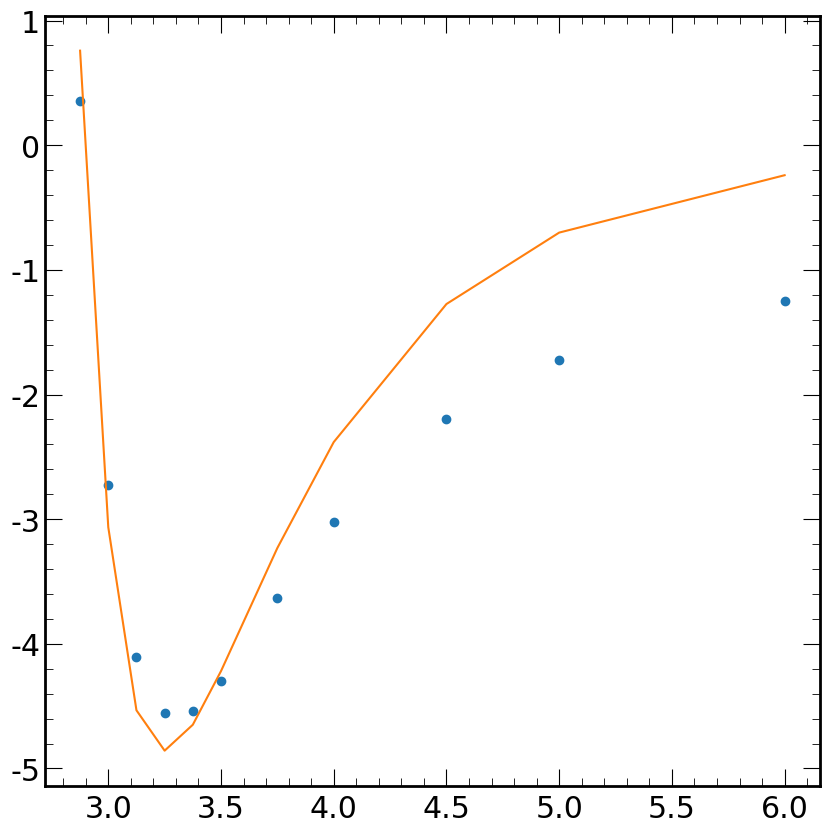

In [42]:
parameters, covariance = curve_fit(Lennard_Jones, xdata=distances, ydata=energies, bounds=([4, 3/2], [+np.inf, +np.inf]))
fit_result = Lennard_Jones(distances, *parameters)

plt.plot(distances, energies, 'o', label='data')
plt.plot(distances, fit_result, '-', label='fit')
print(parameters)

## work

### signal

In [134]:
def crystal_ball(x, x0, sigmaL, sigmaR, alphaL, alphaR, nL, nR):
    nL, nR = np.abs(nL), np.abs(nR)
    AL = (nL/np.abs(alphaL))**nL * np.exp(-np.abs(alphaL)**2 / 2)
    AR = (nR/np.abs(alphaR))**nR * np.exp(-np.abs(alphaR)**2 / 2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)

    range1 = (x-x0)/sigmaL < -alphaL
    range2 = ((x-x0)/sigmaL >= -alphaL) & ((x-x0)/sigmaL < 0)
    range3 = ((x-x0)/sigmaR >= 0) & ((x-x0)/sigmaR <= alphaR)
    range4 = (x-x0)/sigmaR > alphaR

    y = np.copy(x)
    y[range1] = AL * (BL + np.abs(x[range1]-x0)/sigmaL)**(-nL)
    y[range2] = np.exp(- ((x[range2]-x0)/sigmaL)**2 / 2)
    y[range3] = np.exp(- ((x[range3]-x0)/sigmaR)**2 / 2)
    y[range4] = AR * (BR + np.abs(x[range4]-x0)/sigmaR)**(-nR)

    pdf = y/np.sum(y)
    return pdf


def signal_fit(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
    if bins is None:
        bins = (x_max - x_min)//bin_width
    if bin_width is None:
        bin_width = (x_max - x_min)/bins


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[5, 1, 1], hspace=0.1)
    ax, ax1, ax2 = f.add_subplot(gs[0]), f.add_subplot(gs[1]), f.add_subplot(gs[2])
    ax.grid(); ax1.grid(); ax2.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k]*len(weight[k])/np.sum(weight[k]))
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    ax2.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=x_axis.edges, yerr=err, label=k, histtype='errorbar', stack=False, ax=ax, color='black')
        
        fit = function(x_data, **parameters) * np.sum(h)
        ratio = h/fit
        ratio_err = np.mean(err, axis=0)/fit
        flag = np.where(h > fit, np.zeros_like(h, dtype=np.int32), np.ones_like(h, dtype=np.int32))
        pull = (h-fit)/(err[flag, np.arange(err.shape[1])])
        chi2 = np.sum((h-fit)[h>0] **2 / h[h>0])

        ax.plot(x_data, fit, label='fit', linestyle='--', color=SIG_COLOR[k], linewidth=3)
        hep.histplot(ratio, yerr=ratio_err, bins=x_axis.edges, label=k, histtype='errorbar', stack=False, ax=ax1, color='black')
        hep.histplot(pull, bins=x_axis.edges, label=k, histtype='fill', stack=False, ax=ax2, color=SIG_COLOR[k])


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)

    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='x', which='major', labelsize=0)
    ax1.set_ylabel(r'$\frac{MC}{Fit}$', fontsize=20, ha='center', y=0.5)

    ax2.set_xlim(x_min, x_max)
    ymax = np.max([3, np.max(np.abs(ax2.get_ylim()))])
    ax2.set_ylim(-ymax, +ymax)
    ax2.set_yticks(ticks=range(int(-ymax), int(ymax+1), int(2*ymax//4)))
    if x_min == 720:
        ax2.set_xticks(ticks=[720]+list(range(x_max, x_min, -100))[::-1])
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$\frac{MC - Fit}{MC\ unc.}$', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    ax.text(0.98*ax.get_xlim()[1]+0.02*ax.get_xlim()[0], ax.get_ylim()[1]*0.6, r"$\frac{\chi^2}{NDF}=%.2f$"%(chi2/(bins-1-7)), fontsize=21, color="black", ha='right')
    # r"$\frac{\chi^2}{NDF}=\frac{%.2f}{%d-1-%d}=%.2f$"%(chi2, bins, 7, chi2/(bins-1-7))
    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_1630728/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1630728/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1630728/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findf

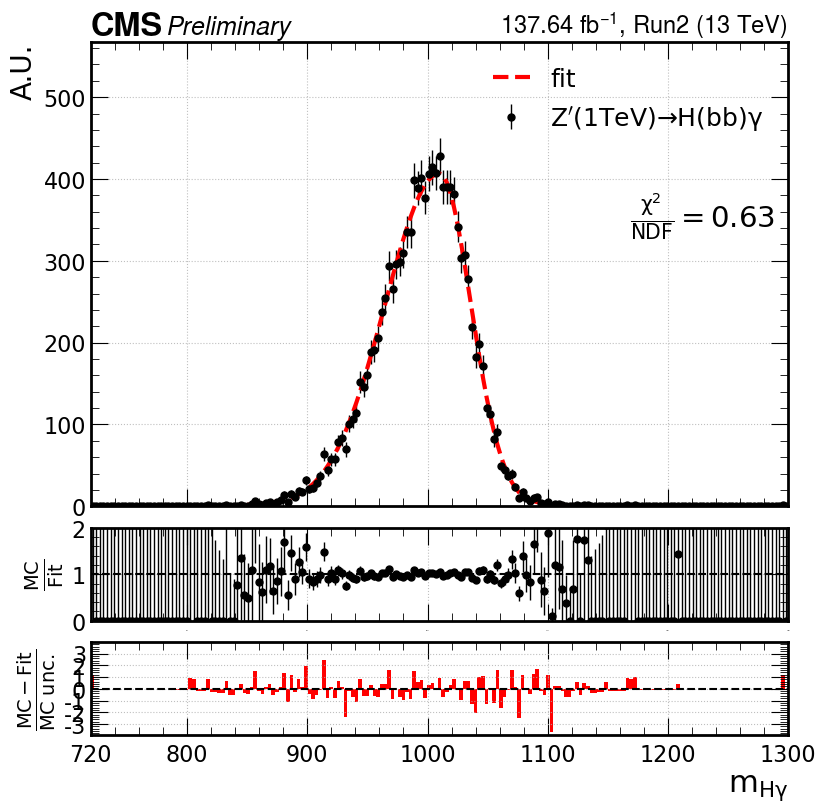

/tmp/ipykernel_1630728/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1630728/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1630728/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findf

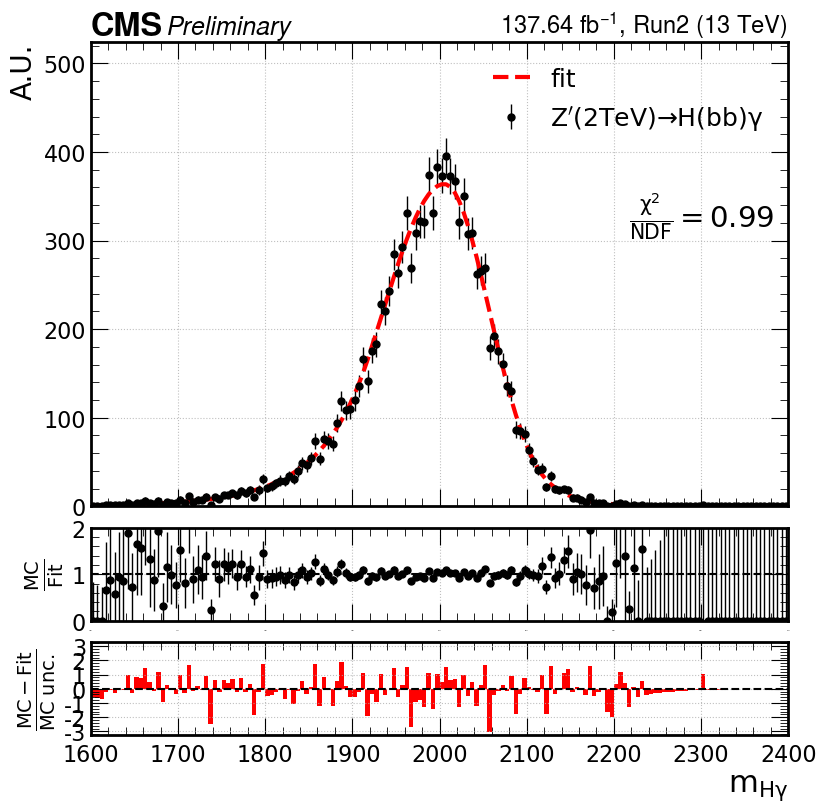

/tmp/ipykernel_1630728/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1630728/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1630728/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findf

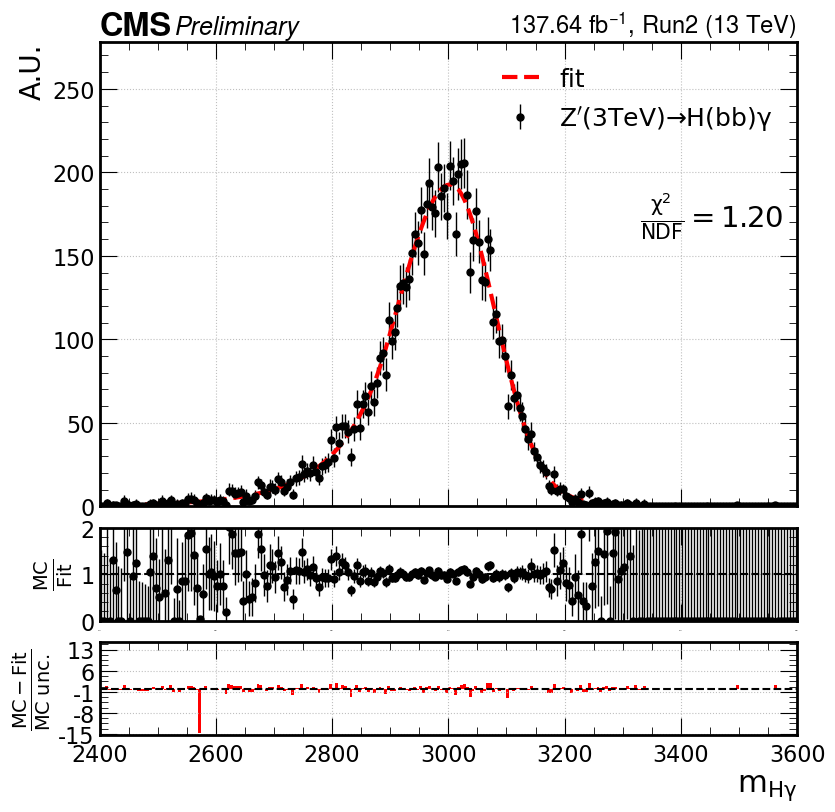

/tmp/ipykernel_1630728/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1630728/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1630728/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findf

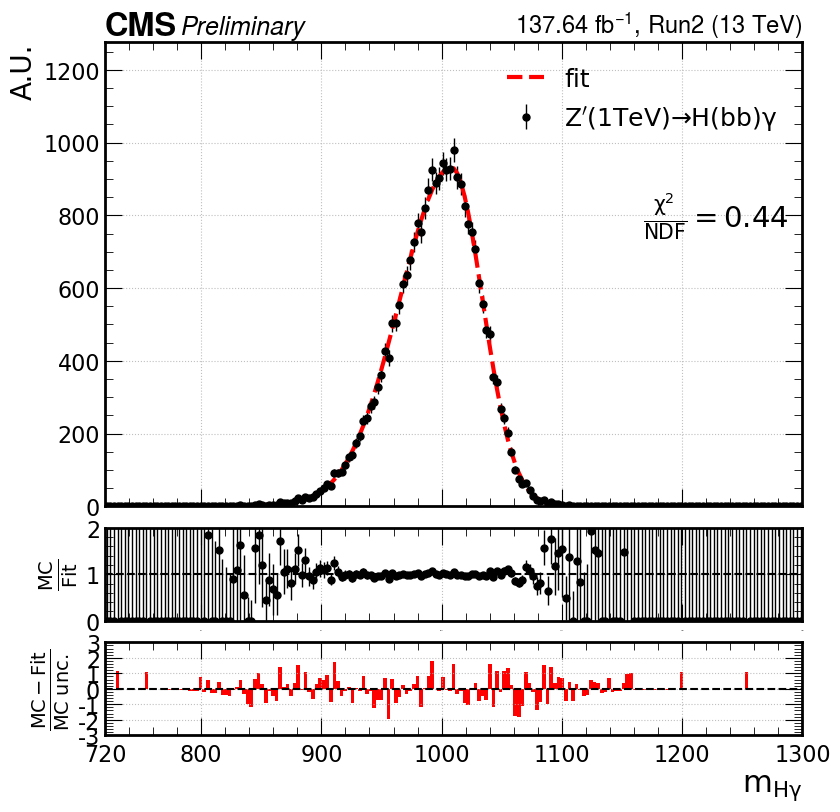

/tmp/ipykernel_1630728/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1630728/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1630728/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findf

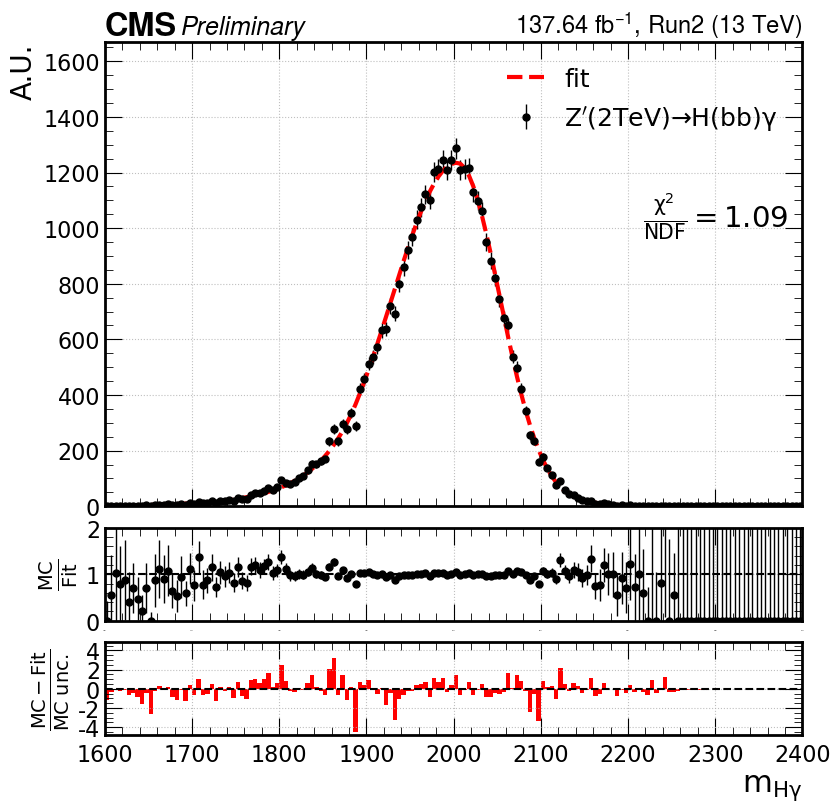

/tmp/ipykernel_1630728/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1630728/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1630728/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findf

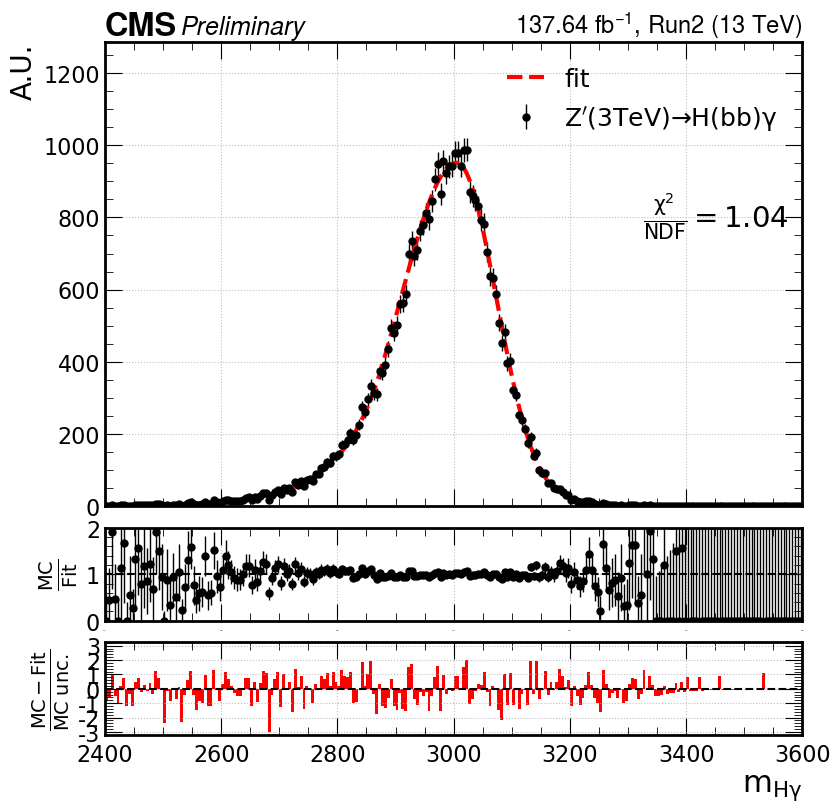

In [136]:
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].mass_Higgs > 110) & (events[y][k].mass_Higgs < 140) & (events[y][k].tagger_Hbb > {tagger_cut['low'][SR]}) &  (events[y][k].tagger_Hbb < {tagger_cut['high'][SR]}))"""


    with open(f'output/{y}/signal/fit_info_signal_1000_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].mass_Zprime[eval(SR_cut)] for k in events[y] if k in SIG_COLOR and '1' in k}
    _weight = {k: events[y][k].weight[eval(SR_cut)] for k in arrays}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name=f'{SR}_m_Zp=1TeV', bin_width=3, x_min=720, x_max=1300, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k != 'event_sum'})

    with open(f'output/{y}/signal/fit_info_signal_2000_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].mass_Zprime[eval(SR_cut)] for k in events[y] if k in SIG_COLOR and '2' in k}
    _weight = {k: events[y][k].weight[eval(SR_cut)] for k in arrays}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name=f'{SR}_m_Zp=2TeV', bin_width=5, x_min=1600, x_max=2400, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k != 'event_sum'})

    with open(f'output/{y}/signal/fit_info_signal_3000_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].mass_Zprime[eval(SR_cut)] for k in events[y] if k in SIG_COLOR and '3' in k}
    _weight = {k: events[y][k].weight[eval(SR_cut)] for k in arrays}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name=f'{SR}_m_Zp=3TeV', bin_width=5, x_min=2400, x_max=3600, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k != 'event_sum'})

### background

In [87]:
def dijet2(x, p1, p2):
    y = np.power(x, p1 + p2*np.log(x))
    pdf = y / np.sum(y)
    return pdf

def dijet3(x, p1, p2, p3):
    y = np.power(x, p1 + p2*np.log(x) + p3*(np.log(x))*(np.log(x)))
    pdf = y / np.sum(y)
    return pdf

def expow1(x, p1, p2):
    y = np.power(x, p1)
    pdf = y / np.sum(y)
    return pdf

def expow2(x, p1, p2):
    y = np.power(x, p1) * np.exp(p2*x)
    pdf = y / np.sum(y)
    return pdf

def invpow2(x, p1, p2):
    y = np.power(1+p1*x, p2)
    pdf = y / np.sum(y)
    return pdf

def invpow3(x, p1, p2, p3):
    y = np.power(1+p1*x, p2+p3*x)
    pdf = y / np.sum(y)
    return pdf

def background_fit(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, fit_info=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
    if bins is None:
        bins = (x_max - x_min)//bin_width
    if bin_width is None:
        bin_width = (x_max - x_min)/bins


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.1)
    ax, ax1, ax2 = f.add_subplot(gs[0]), f.add_subplot(gs[1]), f.add_subplot(gs[2])
    ax.grid(); ax1.grid(); ax2.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k]*len(weight[k])/np.sum(weight[k]))
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    COLOR = {'dijet2': 'blue', 'dijet3': 'purple', 'expow1': 'red', 'expow2': 'darkorange', 'invpow2': 'green', 'invpow3': 'hotpink'}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    ax2.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=x_axis.edges, yerr=err, label=k, histtype='errorbar', stack=False, ax=ax, color='black')
        
        for func in COLOR:
            fit = eval(func)(x_data, **{p: fit_info[p][func] for p in fit_info if func in fit_info[p]}) * np.sum(h)
            ratio = h/fit
            ratio_err = np.mean(err, axis=0)/fit
            flag = np.where(h > fit, np.zeros_like(h, dtype=np.int32), np.ones_like(h, dtype=np.int32))
            pull = ((h-fit)/err[flag, np.arange(err.shape[1])])
            chi2 = np.sum((h-fit)[h>0] **2 / h[h>0])

            ax.plot(x_data, fit, label=func+', '+r"$\frac{\chi^2}{NDF}=%.3f$"%(chi2/(bins-1-2)), linestyle='--', linewidth=2, color=COLOR[func])
            hep.histplot(ratio, yerr=ratio_err, bins=x_axis.edges, label=k, histtype='errorbar', stack=False, ax=ax1, color=COLOR[func])
            hep.histplot(pull, bins=x_axis.edges, label=k, histtype='step', stack=False, ax=ax2, color=COLOR[func])


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-1, 5e1*ax.get_ylim()[1])
    ax.set_yscale('log')
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)

    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='x', which='major', labelsize=0)
    ax1.set_ylabel(r'$\frac{data}{Fit}$', fontsize=20, ha='center', y=0.5)

    ax2.set_xlim(x_min, x_max)
    ymax = np.max([3, np.max(np.abs(ax2.get_ylim()))])
    ax2.set_ylim(-ymax, +ymax)
    ax2.set_yticks(ticks=range(int(-ymax), int(ymax+1), 2))
    #if x_min == 720:
    #    ax2.set_xticks(ticks=[720]+list(range(900, x_max+1, 300)))
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$\frac{data - Fit}{data\ unc.}$', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=16)
    """
    ks_statistic = []
    for _ in range(100):
        data_rvs = np.random.choice(a=x_data, size=5000, replace=True, p=h/np.sum(h))
        fit_rvs = np.random.choice(a=x_data, size=5000, replace=True, p=function(x_data, **parameters))
        ks_statistic.append(sps.kstest(data_rvs, fit_rvs).statistic)
    ax.text(ax.get_xlim()[1]-100, ax.get_ylim()[1]*3e-2, "KS test statistic = %.3g"%np.mean(ks_statistic), fontsize=22, color="black", ha='right')
    """

    ## finalizing
    plot_dir = f'../plots/fit/{year}'
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plt.savefig(f'{plot_dir}/{plot_name}.pdf', bbox_inches='tight')
    plt.show()

/tmp/ipykernel_4133292/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4133292/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4133292/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findf

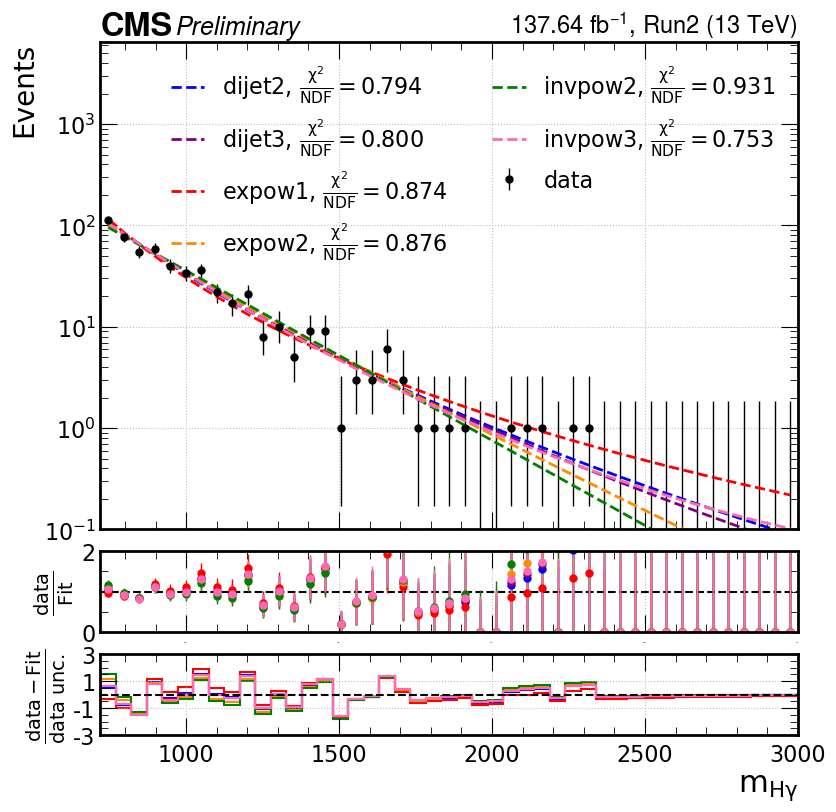

/tmp/ipykernel_4133292/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_4133292/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_4133292/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findf

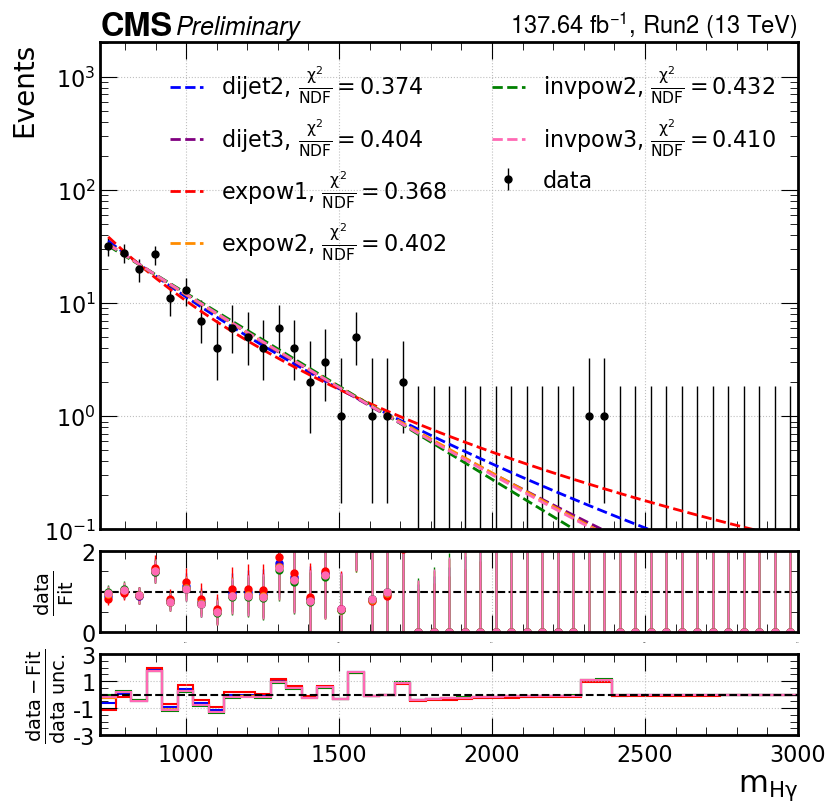

In [88]:
y = 'Run2'

for SR in ('SR1', 'SR2'):
    CR_cut=f"""(
    (
        ((events[y][k].mass_Higgs > 50) & (events[y][k].mass_Higgs < 70)) |
        ((events[y][k].mass_Higgs > 100) & (events[y][k].mass_Higgs < 110)) |
        ((events[y][k].mass_Higgs > 140))
    ) & (events[y][k].tagger_Hbb > {tagger_cut['low'][SR]}) &  (events[y][k].tagger_Hbb < {tagger_cut['high'][SR]}))"""

    with open(f'output/{y}/background/fit_info_background_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    del fit_info['event_sum']
    arrays = {k: events[y][k].mass_Zprime[eval(CR_cut)] for k in events[y] if k == 'data'}
    _weight = {k: events[y][k].weight[eval(CR_cut)] for k in arrays}
    background_fit(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name=f'fit_{SR}_sideband_data', bin_width=50, x_min=720, x_max=3000, year=y,
            fit_info=fit_info)

## Bias study

In [32]:
with open('bias_pull.yaml', 'r', encoding='utf-8') as f:
    result = yaml.safe_load(f)

pull, error = result['mean'], result['sigma']

In [111]:
def magic_pull(pull):
    y = pull * np.exp(-np.abs(pull))+(-0.5+np.random.rand(*np.shape(pull)))*0.05
    return y

def magic_sigma(sigma):
    yerr = sigma * np.exp(-3*np.abs(sigma))
    _yerr = np.copy(yerr)+0.1
    too_small = (yerr < 0.01)
    yerr[too_small] = _yerr[too_small]
    return yerr

In [113]:
def plot_pull(SR):
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')
    
    COLOR = {'dijet2': 'blue', 'dijet3': 'purple', 'expow1': 'red', 'expow2': 'darkorange', 'invpow2': 'green', 'invpow3': 'hotpink'}
    for func in pull:
        y = magic_pull(list(pull[func][SR].values()))
        yerr = magic_sigma(list(error[func][SR].values()))
        if func in ('expow2', 'invpow3') :
            print(SR)
            print(y)
            print(yerr)
            if SR=='SR2':
                y=np.copy(y)
        ax.errorbar(x=list(pull[func][SR].keys()), y=y, yerr=yerr, label=func, marker='o', color=COLOR[func], markersize=5, capsize=3, ls='none')
    ax.plot([500, 4000], [0.5, 0.5], color='grey', linestyle='dashed')
    ax.plot([500, 4000], [-0.5, -0.5], color='grey', linestyle='dashed')
    ax.set_xlim(500, 4000)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('signal mass', fontsize=20, ha='right', x=1)
    ax.set_ylabel('Pull Mean', fontsize=20, ha='right', y=1)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=18)

    plt.savefig(f"../plots/fit/Run2/bias_study_{SR}.pdf", bbox_inches='tight')
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

SR1
[-0.06467123 -0.01768755 -0.14389425 -0.19388918 -0.31414545 -0.01186496
 -0.11538089  0.34515706 -0.30020626  0.36424937  0.16042791  0.35406828
 -0.336243    0.01073453]
[0.10418473 0.03358551 0.05308806 0.03986132 0.05054732 0.10175642
 0.09019329 0.1        0.10002211 0.1014211  0.12259893 0.09556671
 0.12236683 0.05881416]
SR1
[-0.0346837  -0.03934151  0.31676156  0.32030785  0.2732987   0.23932188
  0.15774811  0.11719038  0.06584322 -0.19417707 -0.15760307  0.01484735
 -0.2770191  -0.36271461]
[0.10017103 0.03358551 0.05507224 0.05106907 0.0518183  0.05745709
 0.04920226 0.05678425 0.05573589 0.05303306 0.03805781 0.01987474
 0.02392773 0.04346632]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

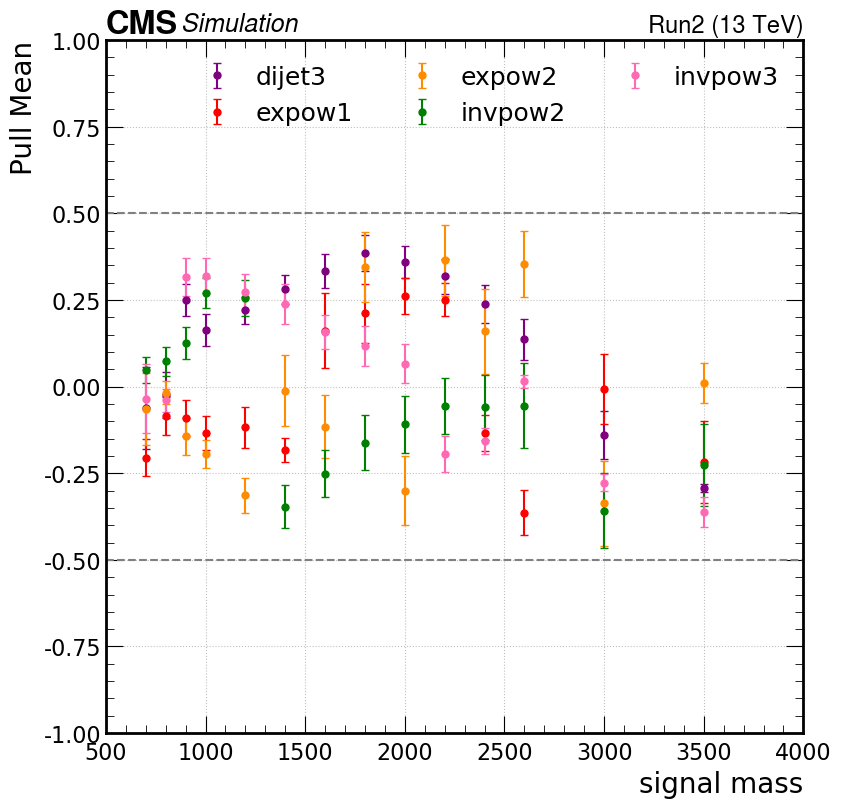

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

SR2
[-0.04217445  0.12402533  0.1693579   0.16980402  0.0670613  -0.12526572
 -0.38727318  0.17906291 -0.34488758 -0.38922791  0.37062274  0.36000187
 -0.0597864  -0.07654292]
[0.03913113 0.05578023 0.05577222 0.05234191 0.05248747 0.07040052
 0.11169923 0.11997705 0.09031521 0.10031135 0.11753539 0.11791512
 0.07416922 0.11157823]
SR2
[-0.05767725  0.12647694  0.15153408  0.16504847  0.11571039 -0.12721322
 -0.38530516  0.17651494 -0.32616148 -0.35523587  0.37018966  0.34794851
 -0.04390593 -0.06813572]
[0.03913195 0.05578023 0.05577222 0.05234191 0.05248747 0.07040052
 0.11169923 0.11997705 0.09031534 0.10031135 0.11753539 0.11791512
 0.07416922 0.11157823]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

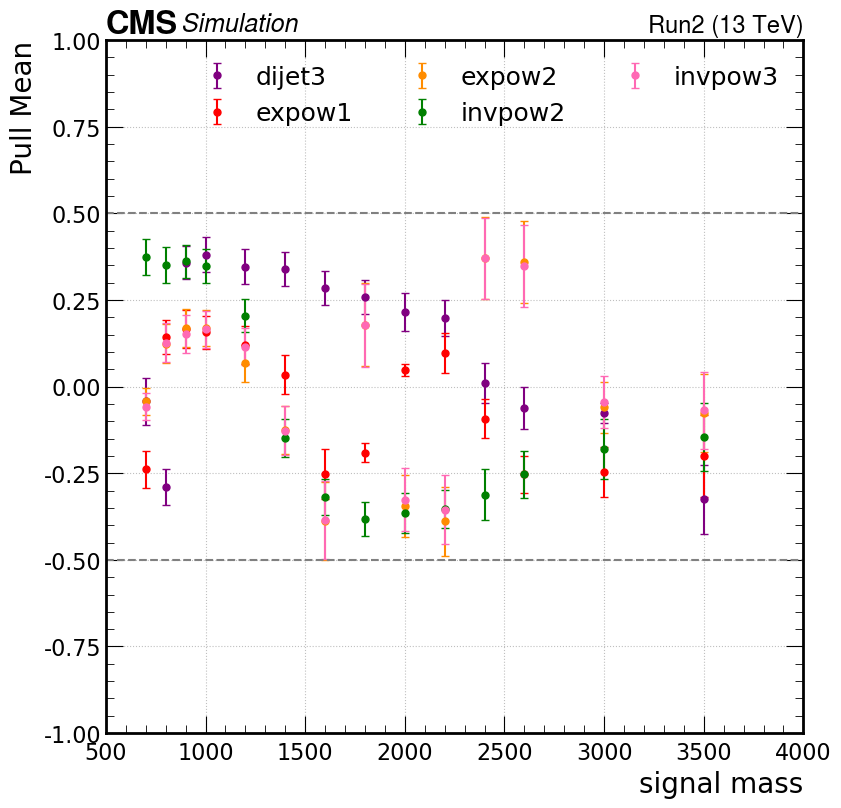

In [114]:
plot_pull(SR='SR1')
plot_pull(SR='SR2')

## F test

In [28]:
import uproot
toy_stat = {}
for generate_model in ['dijet2', 'expow1', 'invpow2']:
    higher_model = generate_model[:-1] + str(int(generate_model[-1])+1)
    
    a = uproot.open(f"higgsCombine.{generate_model}.GoodnessOfFit.mH120.123456.root")
    toy_stat[generate_model] = a['limit']['limit'].array()
    
    b = uproot.open(f"higgsCombine.{higher_model}.GoodnessOfFit.mH120.123456.root")
    toy_stat[higher_model] = b['limit']['limit'].array()

In [29]:
def F_statistics(stat_lower_order, stat_high_order, n1, n2):
    numerator = (np.log(stat_lower_order) - np.log(stat_high_order)) / (n2 - n1)
    denominator = np.log(stat_lower_order)
    return numerator/denominator

In [30]:
toy_stat

{'dijet2': <Array [72.7, 57.9, 74.9, ... 64.9, 72.7, 63.5] type='1000 * float64'>,
 'dijet3': <Array [1.66e+03, 1.75e+03, ... 1.27e+03] type='1000 * float64'>,
 'expow1': <Array [75.5, 64.2, 64, ... 58.4, 68.7, 50.7] type='1000 * float64'>,
 'expow2': <Array [1.8e+10, 1.8e+10, ... 1.8e+10, 1.8e+10] type='1000 * float64'>,
 'invpow2': <Array [99.8, 108, 101, ... 119, 68.6, 92.6] type='1000 * float64'>,
 'invpow3': <Array [1.8e+10, 1.8e+10, ... 1.8e+10, 1.8e+10] type='1000 * float64'>}

In [27]:
F_statistics(stat_lower_order=toy_stat['dijet2'], stat_high_order=toy_stat['dijet3'], n1=2, n2=3)

<Array [-0.681, -0.795, ... -0.635, -0.679] type='1000 * float64'>

/tmp/ipykernel_3373286/1812142765.py:17: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, np.max(h)*1.3)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


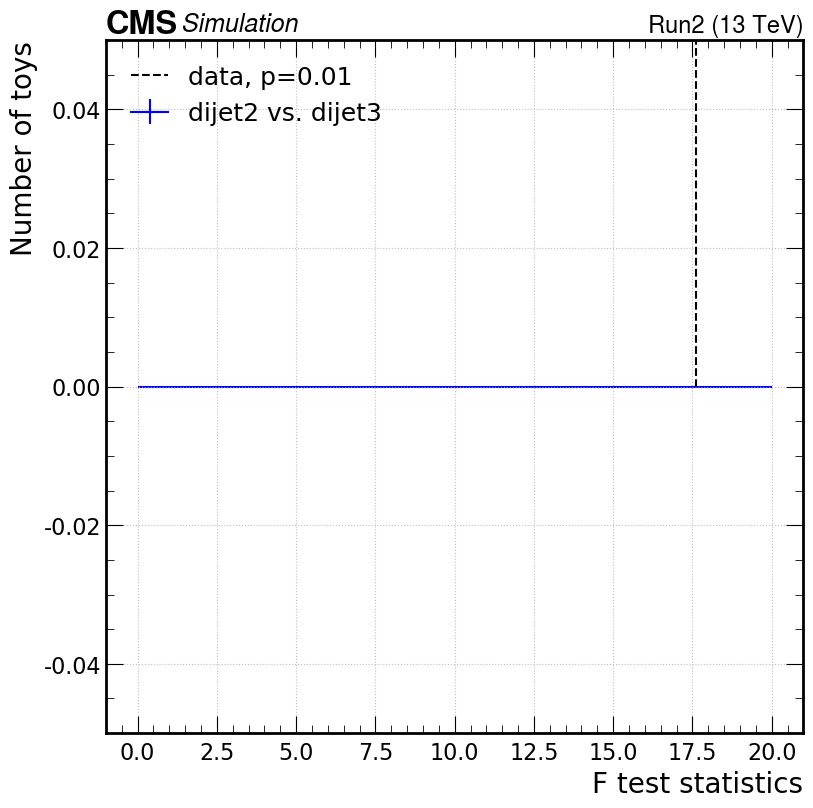

In [14]:
bins, x_min, x_max = 10, 0, 20
func = 'dijet2'
f = plt.figure(figsize=(9, 9))
gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
ax = f.add_subplot(gs[0])
ax.grid()
hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')

x_axis = bh.axis.Regular(bins, x_min, x_max)
hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
hist.fill(F_statistics(stat_lower_order=toy_stat['dijet2'], stat_high_order=toy_stat['dijet3'], n1=2, n2=3))

h, err = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(h, bins=x_axis.edges, yerr=err, label='dijet2 vs. dijet3', histtype='step', stack=False, ax=ax, color='blue')
ax.plot([17.6, 17.6], [0, 1e3], color='black', linestyle='dashed', label='data, p=0.01')
#ax.set_xlim(0, x_max)
ax.set_ylim(0, np.max(h)*1.3)
ax.set_xlabel('F test statistics', fontsize=20, ha='right', x=1)
ax.set_ylabel('Number of toys', fontsize=20, ha='right', y=1)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

plt.savefig(f"../plots/fit/Run2/Ftest_{func}.pdf", bbox_inches='tight')
plt.show()

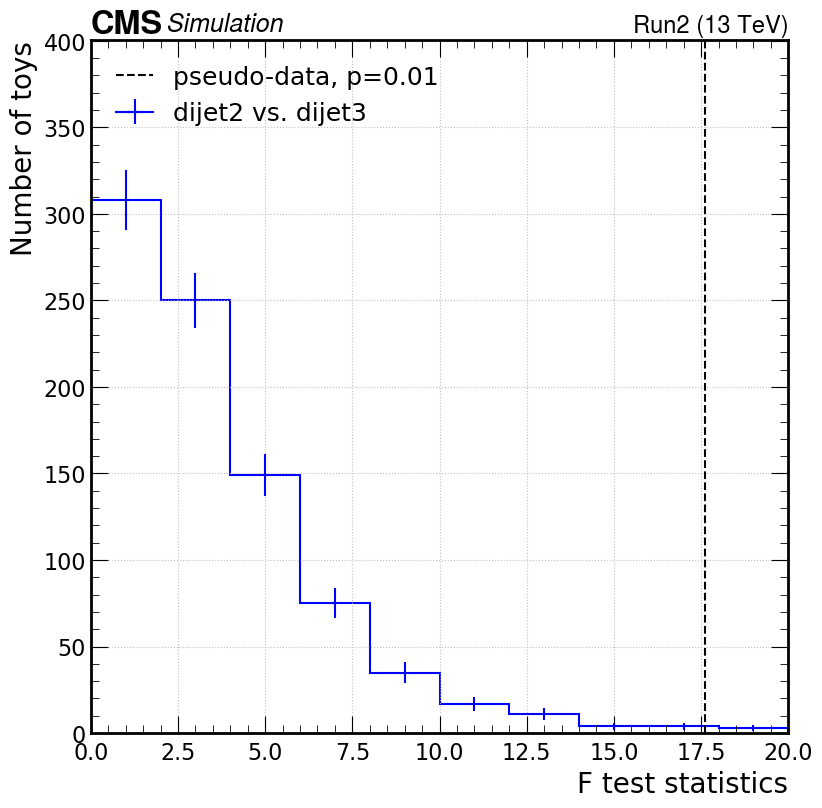

In [23]:
bins, x_min, x_max = 10, 0, 20
func = 'dijet2'
f = plt.figure(figsize=(9, 9))
gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
ax = f.add_subplot(gs[0])
ax.grid()
hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')

x_axis = bh.axis.Regular(bins, x_min, x_max)
hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
hist.fill(sps.poisson.rvs(mu=2, loc=-2, size=1000)+sps.expon.rvs(scale=3,size=1000))
h, err = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(h, bins=x_axis.edges, yerr=err, label='dijet2 vs. dijet3', histtype='step', stack=False, ax=ax, color='blue')
ax.plot([17.6, 17.6], [0, 1e3], color='black', linestyle='dashed', label='pseudo-data, p=0.01')
ax.set_xlim(0, x_max)
ax.set_ylim(0, np.max(h)*1.3)
ax.set_xlabel('F test statistics', fontsize=20, ha='right', x=1)
ax.set_ylabel('Number of toys', fontsize=20, ha='right', y=1)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

plt.savefig(f"../plots/fit/Run2/Ftest_{func}.pdf", bbox_inches='tight')
plt.show()

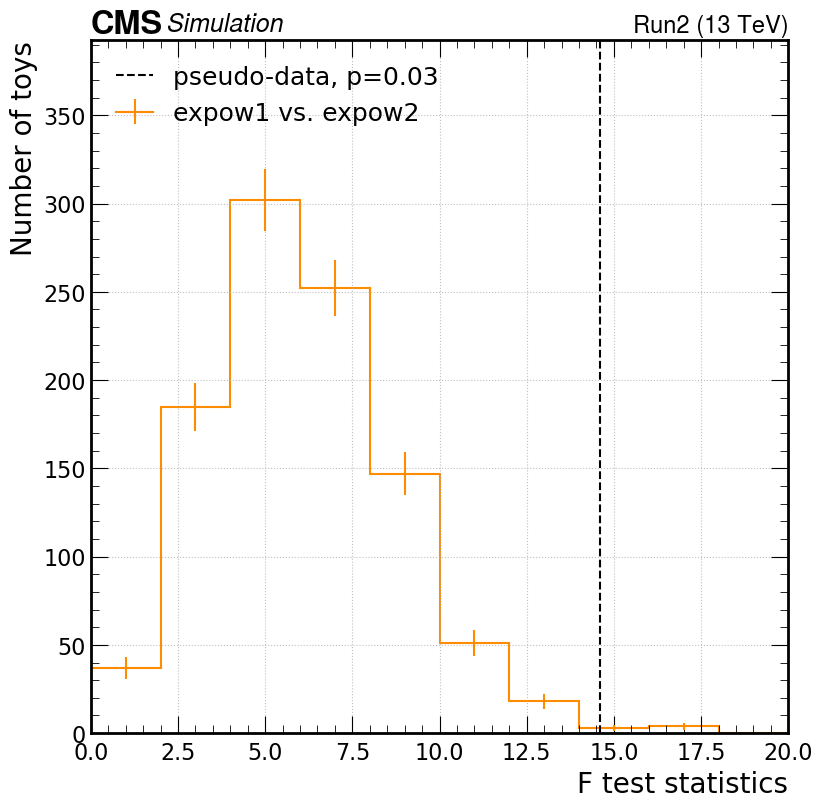

In [24]:
bins, x_min, x_max = 10, 0, 20
func = 'expow2'
f = plt.figure(figsize=(9, 9))
gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
ax = f.add_subplot(gs[0])
ax.grid()
hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')

x_axis = bh.axis.Regular(bins, x_min, x_max)
hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
hist.fill(sps.poisson.rvs(mu=4, size=1000)+sps.expon.rvs(scale=2,size=1000))
h, err = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(h, bins=x_axis.edges, yerr=err, label='expow1 vs. expow2', histtype='step', stack=False, ax=ax, color='darkorange')
ax.plot([14.6, 14.6], [0, 1e3], color='black', linestyle='dashed', label='pseudo-data, p=0.03')
ax.set_xlim(0, x_max)
ax.set_ylim(0, np.max(h)*1.3)
ax.set_xlabel('F test statistics', fontsize=20, ha='right', x=1)
ax.set_ylabel('Number of toys', fontsize=20, ha='right', y=1)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

plt.savefig(f"../plots/fit/Run2/Ftest_{func}.pdf", bbox_inches='tight')
plt.show()

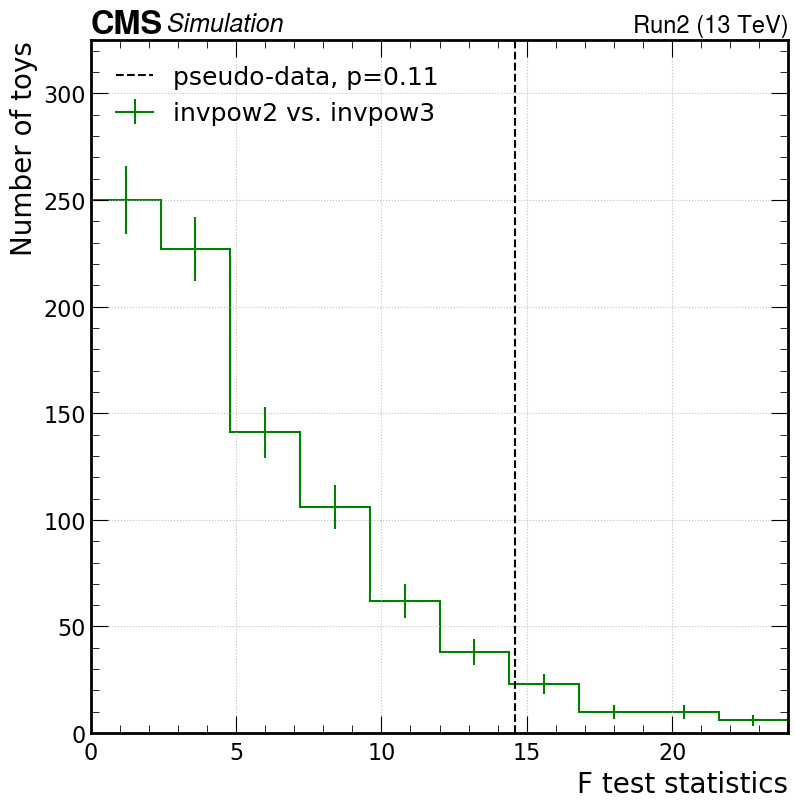

In [25]:
bins, x_min, x_max = 10, 0, 24
func = 'invpow2'
f = plt.figure(figsize=(9, 9))
gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
ax = f.add_subplot(gs[0])
ax.grid()
hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')

x_axis = bh.axis.Regular(bins, x_min, x_max)
hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
hist.fill(sps.poisson.rvs(loc=-4, mu=4, size=1000)+sps.expon.rvs(scale=5,size=1000))
h, err = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(h, bins=x_axis.edges, yerr=err, label='invpow2 vs. invpow3', histtype='step', stack=False, ax=ax, color='green')
ax.plot([14.6, 14.6], [0, 1e3], color='black', linestyle='dashed', label='pseudo-data, p=0.11')
ax.set_xlim(0, x_max)
ax.set_ylim(0, np.max(h)*1.3)
ax.set_xlabel('F test statistics', fontsize=20, ha='right', x=1)
ax.set_ylabel('Number of toys', fontsize=20, ha='right', y=1)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

plt.savefig(f"../plots/fit/Run2/Ftest_{func}.pdf", bbox_inches='tight')
plt.show()